In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from PIL import Image # Importing PIL Image

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# <span style="color:#e74c3c;"> Preprocessing </span>


Original train image path: Dental_Radiography\train\0352_jpg.rf.3e2a868ce6e6b1ad410c236156cb260c.jpg


Text(0.5, 1.0, 'after image processing operations')

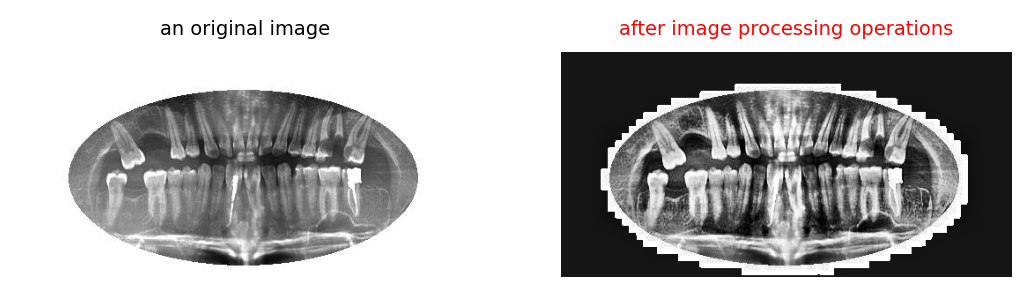

In [4]:
# Importing dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Choosing a random image from the train dataset
original_train_images = sorted(os.listdir(r'Dental_Radiography\train'))
org_img_path = np.random.permutation(original_train_images)[0]
image_path = os.path.join(r'Dental_Radiography\train', org_img_path)

# Debugging step: Print the image path
print("Original train image path:", image_path)

# Check if the image file exists
if not os.path.exists(image_path):
    raise ValueError(f"Image file does not exist: {image_path}")

# Reading the image
img = cv2.imread(image_path)

# Handle case where image cannot be read
if img is None:
    raise ValueError(f"Image not found or cannot be read: {image_path}")

# Proceed with image processing
img = img[:, :, 1]

# A basic segmentation of the image from the background
img2 = img - 255
kernel = np.ones((2,2))
kernel2 = np.ones((3,3))
dilated_mask = cv2.dilate(img2, kernel, iterations=3)
ret, thresh = cv2.threshold(dilated_mask, 0, 255, cv2.THRESH_BINARY)
dilated_mask2 = cv2.dilate(thresh, kernel2, iterations=3)
img = img / 255.0
res_img = dilated_mask2 * img
res_img = np.uint8(res_img)

# CLAHE operation
clahe_op = cv2.createCLAHE(clipLimit=20)
final_img = clahe_op.apply(res_img)

# Displaying the images
fig, axs = plt.subplots(1, 2, dpi=200)

axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[0].set_title('an original image', fontsize=7)

axs[1].imshow(final_img, cmap='gray')
axs[1].axis('off')
axs[1].set_title('after image processing operations', fontsize=7, color='red')

In [5]:
# Creating new directories
os.makedirs(os.path.join('Dental_Radiography', 'working', 'train'), exist_ok=True)
os.makedirs(os.path.join('Dental_Radiography', 'working', 'valid'), exist_ok=True)
os.makedirs(os.path.join('Dental_Radiography', 'working', 'test'), exist_ok=True)

In [6]:
# Image processing function
# reading -> background segmentation -> adaptive histogram equalization (CLAHE)
def new_img(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs:
        try:
            img = cv2.imread(os.path.join(main_path, i))[:, :, 1]
            img2 = img - 255
            kernel = np.ones((2,2))
            kernel2 = np.ones((3,3))
            dilated_mask = cv2.dilate(img2, kernel, iterations=3)
            ret, thresh = cv2.threshold(dilated_mask, 0, 255, cv2.THRESH_BINARY)
            dilated_mask2 = cv2.dilate(thresh, kernel2, iterations=3)
            img = img / 255.0
            res_img = dilated_mask2 * img
            res_img = np.uint8(res_img)
            clahe_op = cv2.createCLAHE(clipLimit=20)  # CLAHE function
            final_img = clahe_op.apply(res_img)
            cv2.imwrite(os.path.join(target_path, i), final_img)
        except TypeError:
            pass

In [7]:
# Applying the image processing function to all images
new_img(r'Dental_Radiography\train', r'Dental_Radiography\working\train')
new_img(r'Dental_Radiography\valid', r'Dental_Radiography\working\valid')
new_img(r'Dental_Radiography\test', r'Dental_Radiography\working\test')

In [8]:
# Importing dependencies
import pandas as pd

# Reading CSV files
train_data = pd.read_csv(r'Dental_Radiography\train\_annotations.csv')
validation_data = pd.read_csv(r'Dental_Radiography\valid\_annotations.csv')
test_data = pd.read_csv(r'Dental_Radiography\test\_annotations.csv')

# Look-up table
classes = {0: 'Fillings', 1: 'Implant', 2: 'Impacted Tooth', 3: 'Cavity'}

def create_classes(X):
    if X == 'Fillings':
        return 0
    elif X == 'Implant':
        return 1
    elif X == 'Impacted Tooth':
        return 2
    elif X == 'Cavity':
        return 3
    else:
        print('MISSING')

# Encoding class labels
train_data['encoded_class'] = train_data['class'].apply(create_classes)
validation_data['encoded_class'] = validation_data['class'].apply(create_classes)
test_data['encoded_class'] = test_data['class'].apply(create_classes)

# Creating full paths
train_data['full_path'] = r'Dental_Radiography\working\train\\' + train_data['filename']
validation_data['full_path'] = r'Dental_Radiography\working\valid\\' + validation_data['filename']
test_data['full_path'] = r'Dental_Radiography\working\test\\' + test_data['filename']

# Print the number of images
print("train images: ", train_data.shape[0])
print("validation images: ", validation_data.shape[0])
print("test images: ", test_data.shape[0])

train images:  8030
validation images:  780
test images:  473


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [10]:
# Simplified transformation for testing
simple_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [11]:
# Custom dataset class
class DentalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        print("Dataset initialized with", len(dataframe), "samples")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.normpath(self.dataframe.iloc[idx, -1])
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, -2]

        if self.transform:
            image = self.transform(image)
        
        # print(f"Loaded image: {img_path}, Label: {label}")
        return image, label

# Create datasets
train_dataset = DentalDataset(train_data, transform=simple_transform)
valid_dataset = DentalDataset(validation_data, transform=simple_transform)
test_dataset = DentalDataset(test_data, transform=simple_transform)

Dataset initialized with 8030 samples
Dataset initialized with 780 samples
Dataset initialized with 473 samples


In [12]:
from torch.utils.data import DataLoader

# Define constants
SEED = 10
IMG_SIZE = (256, 256)
BATCH_SIZE = 16

# Custom dataset class and transform functions are already defined
# Creating dataset loaders with reduced number of workers
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for testing
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 for testing
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 for testing
    pin_memory=True
)

In [13]:
# Test data loaders with detailed debugging
print("Testing data loaders...")

# We will limit the number of batches to test to avoid getting stuck for too long
test_batches = 3

try:
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Batch {batch_idx+1}/{len(train_loader)}")
        print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
        if batch_idx >= test_batches - 1:
            break  # Test only the first few batches
except Exception as e:
    print(f"Data loader error: {e}")

print("Data loader test completed.")

Testing data loaders...
Batch 1/502
Images shape: torch.Size([16, 3, 256, 256]), Labels shape: torch.Size([16])
Batch 2/502
Images shape: torch.Size([16, 3, 256, 256]), Labels shape: torch.Size([16])
Batch 3/502
Images shape: torch.Size([16, 3, 256, 256]), Labels shape: torch.Size([16])
Data loader test completed.


# <span style="color:#e74c3c;"> DenseNet201 </span> Model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class DentalNet(nn.Module):
    def __init__(self):
        super(DentalNet, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # Remove the existing classifier
        
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(num_features, 256),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.ELU(),
            nn.Linear(32, 4),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.densenet.features(x)
        x = self.fc(x)
        return x

# Initialize the model and move it to the device
model = DentalNet().to(device)
print("DenseNet201 model initialized and moved to device.")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define early stopping and learning rate reduction
early_stopping_patience = 15
reduce_lr_patience = 7
reduce_lr_factor = 0.1

class EarlyStopping:
    def __init__(self, patience=early_stopping_patience, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class ReduceLROnPlateau:
    def __init__(self, optimizer, factor=reduce_lr_factor, patience=reduce_lr_patience, min_lr=1e-7):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = None

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self._reduce_lr()
                self.counter = 0
        else:
            self.best_loss = val_loss
            self.counter = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            new_lr = max(param_group['lr'] * self.factor, self.min_lr)
            if param_group['lr'] > self.min_lr:
                param_group['lr'] = new_lr
                print(f"Reducing learning rate to {new_lr}")

# Initialize early stopping and LR reduction
early_stopping = EarlyStopping()
reduce_lr = ReduceLROnPlateau(optimizer)

# Training loop
num_epochs = 60
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training loop...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx+1}/{len(train_loader)}")

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f"Validation Batch {batch_idx+1}/{len(valid_loader)}")
            
    val_loss /= len(valid_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    
    early_stopping(val_loss)
    reduce_lr.step(val_loss)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model with loss: {val_loss:.4f}")

print("Training completed.")

Using device: cuda
DenseNet201 model initialized and moved to device.
Starting training loop...
Epoch 1/60
Batch 1/502
Batch 11/502
Batch 21/502
Batch 31/502
Batch 41/502
Batch 51/502
Batch 61/502
Batch 71/502
Batch 81/502
Batch 91/502
Batch 101/502
Batch 111/502
Batch 121/502
Batch 131/502
Batch 141/502
Batch 151/502
Batch 161/502
Batch 171/502
Batch 181/502
Batch 191/502
Batch 201/502
Batch 211/502
Batch 221/502
Batch 231/502
Batch 241/502
Batch 251/502
Batch 261/502


In [ ]:
hist = model.fit(train_dataset, epochs = 60, validation_data = valid_dataset, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Training</span> Results

In [ ]:
# Plotting the training history
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
axs[0].grid(linestyle='dashdot')
axs[0].plot(train_losses, label='train loss')
axs[0].plot(val_losses, label='validation loss')
axs[0].set_xlabel('epochs', fontsize=10)
axs[0].legend(['train loss', 'validation loss'], fontsize=10)

axs[1].grid(linestyle='dashdot')
axs[1].plot(train_accuracies, label='train accuracy')
axs[1].plot(val_accuracies, label='validation accuracy')
axs[1].set_xlabel('epochs', fontsize=10)
axs[1].legend(['train accuracy', 'validation accuracy'], fontsize=10)

plt.show()

# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [ ]:
with strategy.scope():
    test_eval = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))

In [ ]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred = np.argmax(pred, axis = 1)

# <span style="color:#e74c3c;"> Classification </span> Report

In [ ]:
clf = classification_report(test_data['encoded_class'], pred, target_names = list(classes.values()))
print(clf)

# <span style="color:#e74c3c;"> Confusion </span> Matrix

In [ ]:
cm = confusion_matrix(test_data['encoded_class'], pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(6,6))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [ ]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred[idx[i]]) == label:
            axs[i].imshow(img , cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img , cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

In [ ]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction()
random_test_sample_with_prediction()
random_test_sample_with_prediction()
random_test_sample_with_prediction()